# Illinois Analysis
In this notebook, we do a deep dive into Illinois, for which we have the most feature-rich data.
We first train some basic algorithms, including KNN and Linear Regression, then we compare to that the result of XGBoost.
The features are School-level demographic data, and the targets are SAT Math scores.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mode



In [35]:
#Import that data
df19 = pd.read_csv("../data/IL19/IL19_Combined_Ed_Demographic.csv")
df20 = pd.read_csv("../data/IL20/IL20_Combined_Ed_Demographic.csv")
df21 = pd.read_csv("../data/IL21/IL21_Combined_Ed_Demographic.csv")
df22 = pd.read_csv("../data/IL22/IL22_Combined_Ed_Demographic.csv")
df23 = pd.read_csv("../data/IL23/IL23_Combined_Ed_Demographic.csv")
df19.columns

Index(['RCDTS', 'Type', 'School Name', 'District', 'City', 'County',
       'District Type', 'School Type', 'Grades Served',
       'Summative Designation', 'Summative Designation: Student Group(s)',
       'Title 1 Status', '# Student Enrollment',
       '% Student Enrollment - White',
       '% Student Enrollment - Black or African American',
       '% Student Enrollment - Hispanic or Latino',
       '% Student Enrollment - Asian',
       '% Student Enrollment - Native Hawaiian or Other Pacific Islander',
       '% Student Enrollment - American Indian or Alaska Native',
       '% Student Enrollment - Two or More Races',
       '% Student Enrollment - Children with Disabilities',
       '% Student Enrollment - EL', '% Student Enrollment - IEP',
       '% Student Enrollment - Low Income', '% Student Enrollment - Homeless',
       'Total Number of School Days', 'Student Attendance Rate',
       'Student Chronic Truancy Rate', 'High School Dropout Rate - Total',
       'Avg Class Size - 

In [43]:
df_combined = pd.concat([df19,
                         df20,
                         df21,
                         df22,
                         df23],ignore_index=True)

# Remove duplicates (if duplicate rows aren't necessary)
df_combined = df_combined.drop_duplicates(subset=['School Name', 'Year'])
df_combined = df_combined.dropna(subset=['SAT Math Average'])



# First, make sure it's numeric (in case you've got leftover '*' entries too)
df_combined['SAT Math Average'] = pd.to_numeric(df_combined['SAT Math Average'], errors='coerce')

# Now drop rows where it's 0 or NaN
df_combined = df_combined[df_combined['SAT Math Average'] > 0]

dfs = [df19,df20,df21,df22,df23]

for df in dfs:
    df = df[df['SAT Math Average'] > 0]
    df=df.dropna(subset=["SAT Math Average"])
    


## Exploratory Data Analysis
Let's do some initial looks at our data

/tmp/ipykernel_15558/2317201431.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


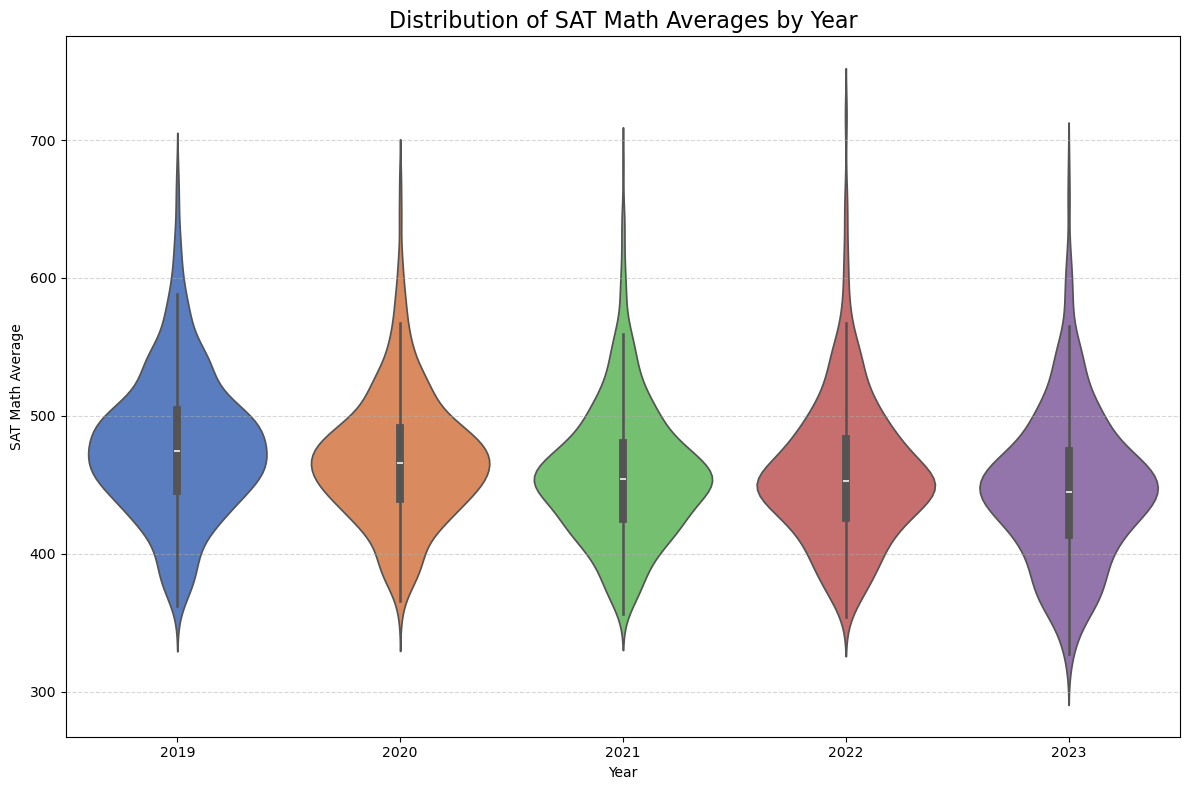

In [44]:
# Make sure 'Year' is treated as categorical for proper spacing
df_combined['Year'] = df_combined['Year'].astype(str)

plt.figure(figsize=(12, 8))
sns.violinplot(
    data=df_combined,
    x='Year',
    y='SAT Math Average',
    inner='box',         # Show a mini boxplot inside each violin
    palette='muted'
)

plt.title('Distribution of SAT Math Averages by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('SAT Math Average')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

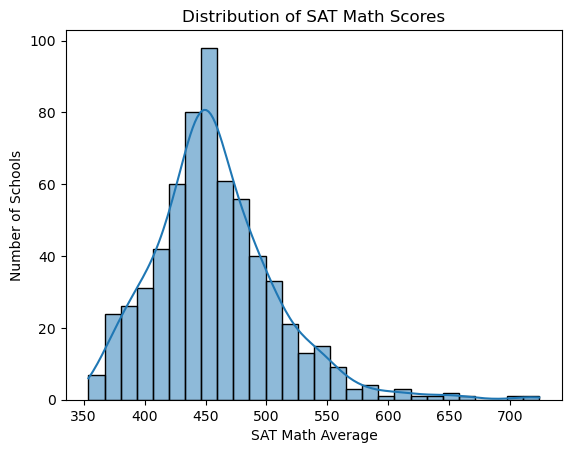

In [5]:
sns.histplot(df22['SAT Math Average'], kde=True)
plt.title("Distribution of SAT Math Scores")
plt.xlabel("SAT Math Average")
plt.ylabel("Number of Schools")
plt.show()

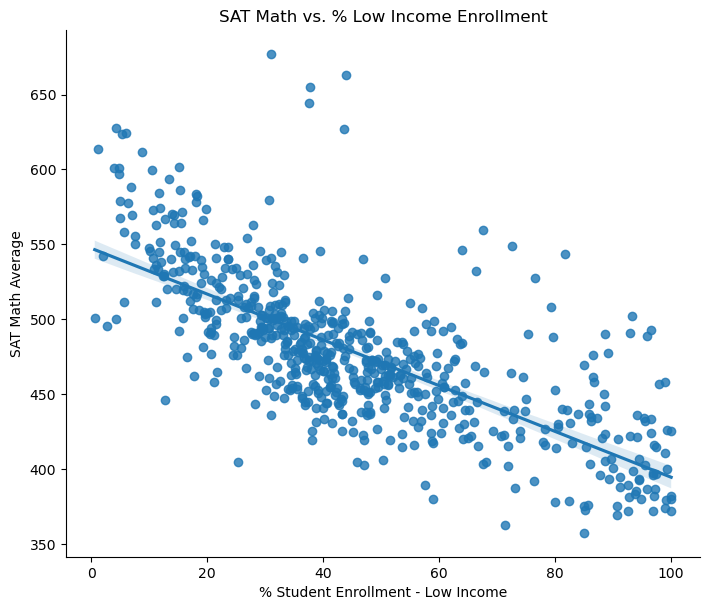

In [6]:
sns.lmplot(data=df19, x='% Student Enrollment - Low Income', y='SAT Math Average', height=6, aspect=1.2)
plt.title("SAT Math vs. % Low Income Enrollment")
plt.show()


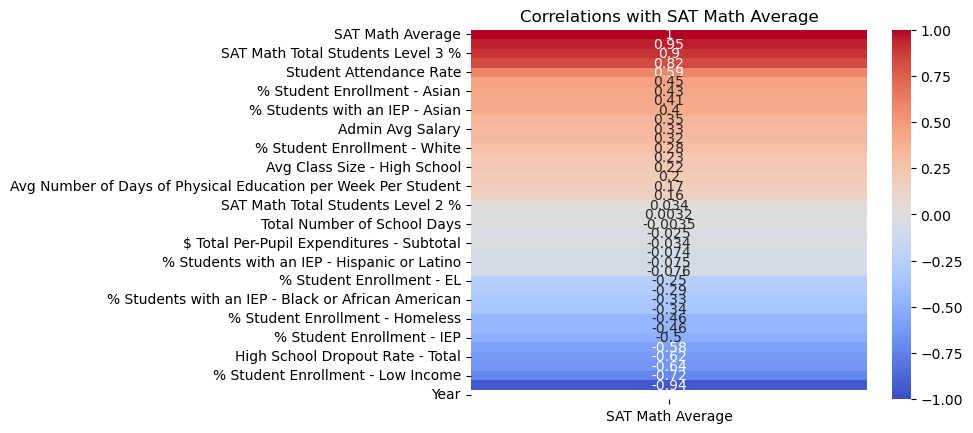

In [7]:

# Filter to numeric columns
numeric_cols = df19.select_dtypes(include=[np.number])

# Compute correlations
corr = numeric_cols.corr()

# Plot heatmap
sns.heatmap(corr[['SAT Math Average']].sort_values(by='SAT Math Average', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlations with SAT Math Average")
plt.show()


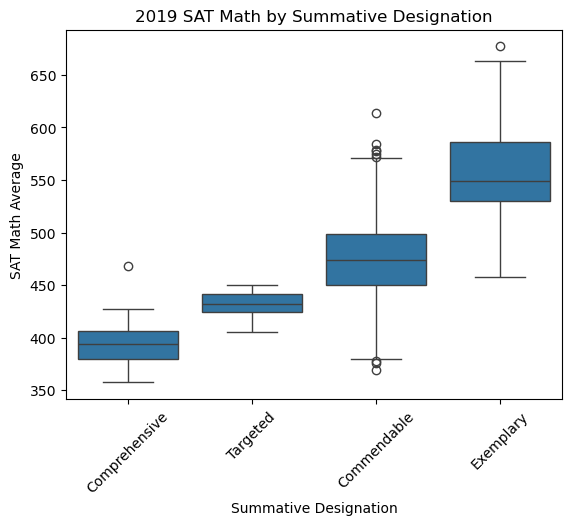

In [8]:
sns.boxplot(
    data=df19,
    x='Summative Designation',
    y='SAT Math Average',
    order=["Comprehensive", "Targeted", "Commendable", "Exemplary"]  # custom order
)
plt.xticks(rotation=45)
plt.title("2019 SAT Math by Summative Designation")
plt.show()


#### Let's make a pair plot of the most strongly correlated features with SAT math score, positive and negative

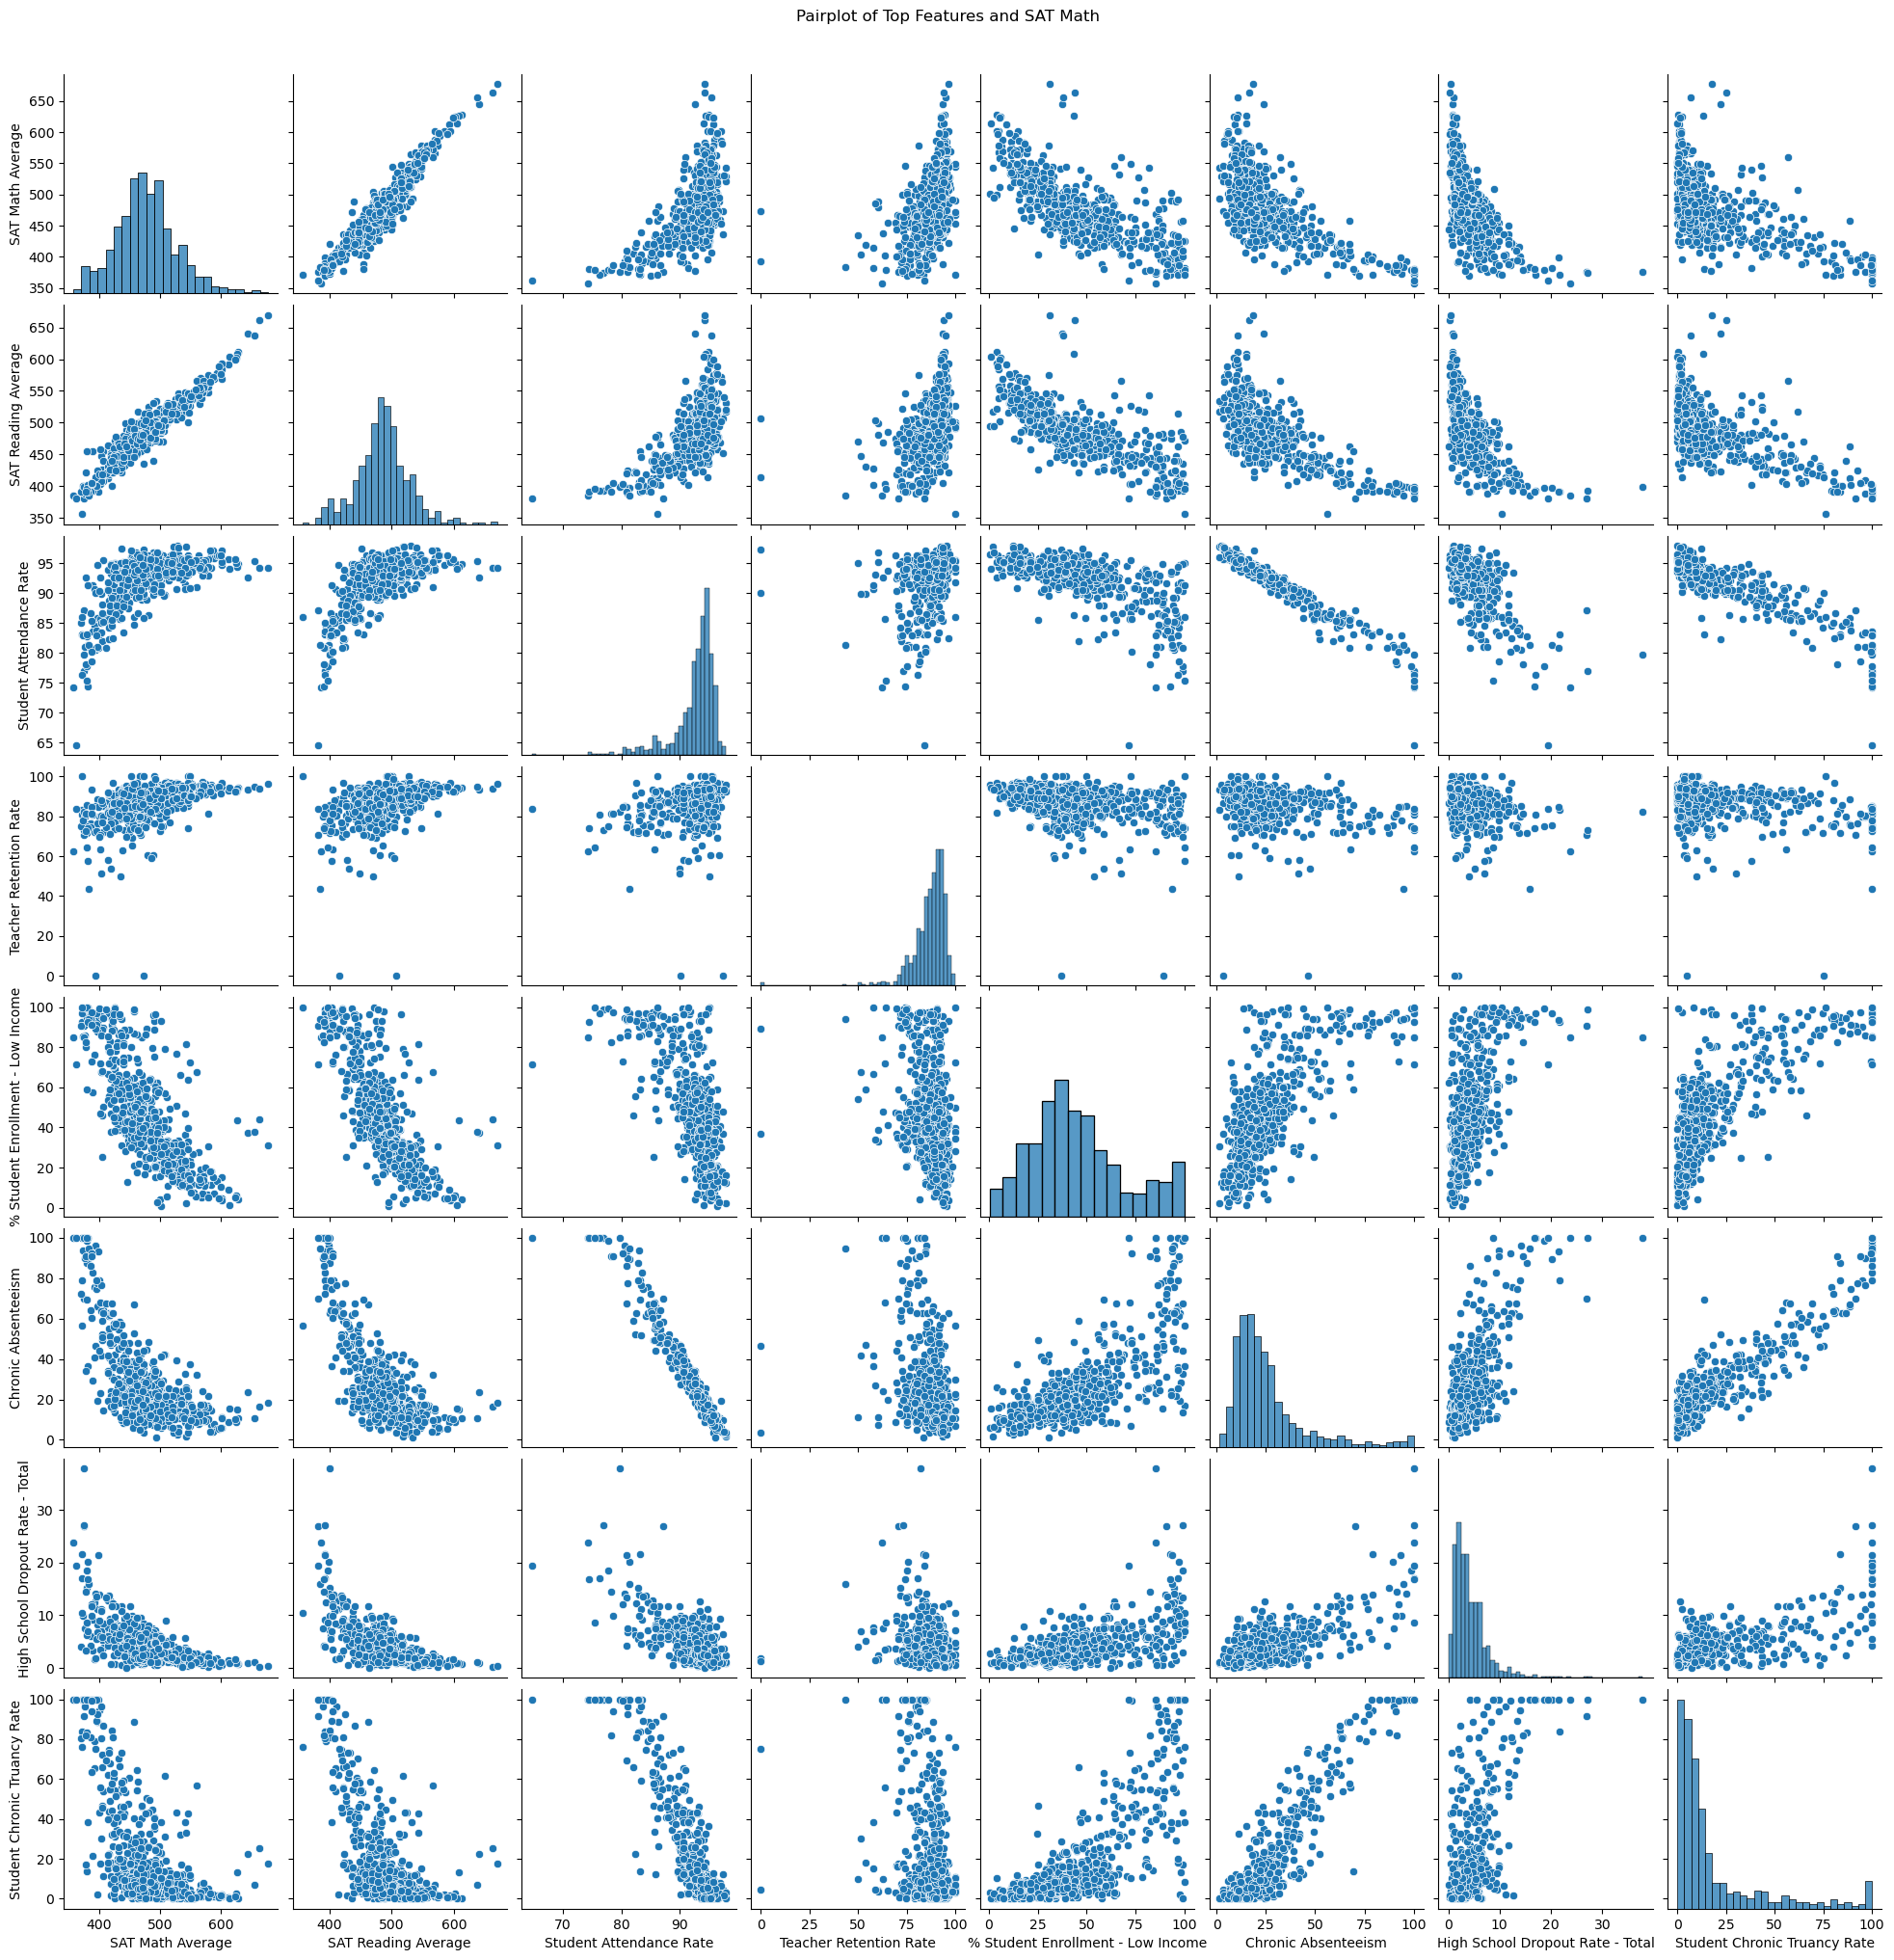

In [24]:
# Sort the correlation values with SAT Math Average
sorted_corr = corr[['SAT Math Average']].sort_values(by='SAT Math Average', ascending=False)

# Get top and bottom features by their index labels (i.e., feature names)
top_features = sorted_corr.iloc[[0, 1, 4, 5]].index.tolist()
bottom_features = sorted_corr.iloc[[-3, -4, -5, -6]].index.tolist()

# Combine them into one list
top_feats = top_features + bottom_features

sns.pairplot(df19[top_feats].dropna())
plt.suptitle("Pairplot of Top Features and SAT Math", y=1.02)
plt.show()

#### What about money spent per pupil at a school? Any correlation?

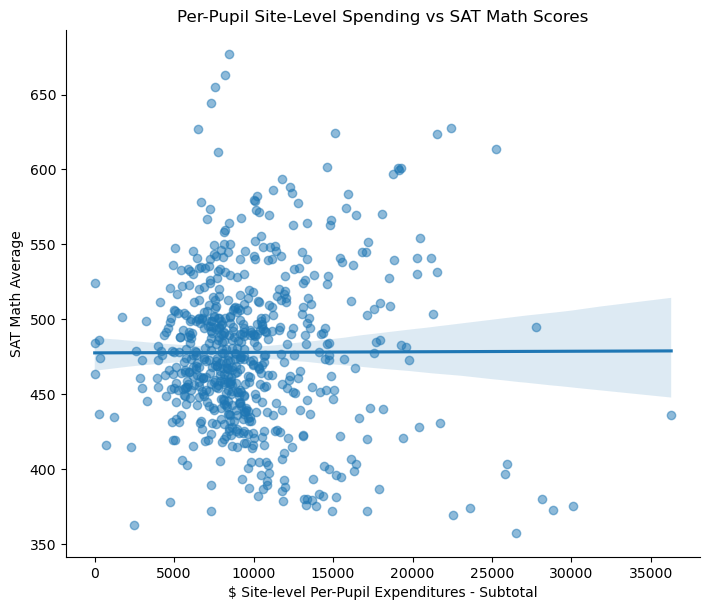

In [57]:
sns.lmplot(
    data=df19,
    x='$ Site-level Per-Pupil Expenditures - Subtotal',
    y='SAT Math Average',
    height=6,
    aspect=1.2,
    scatter_kws={'alpha': 0.5}
)
plt.title("Per-Pupil Site-Level Spending vs SAT Math Scores")
plt.show()


#### Surprising! Seemingly no correlation at all! What if we color code points by % of low income students?

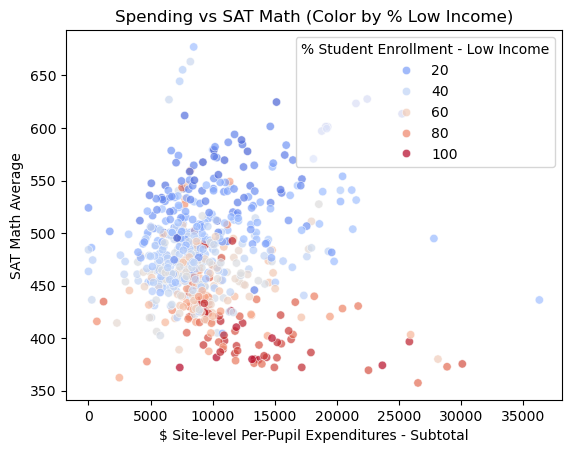

In [30]:
sns.scatterplot(
    data=df19,
    x='$ Site-level Per-Pupil Expenditures - Subtotal',
    y='SAT Math Average',
    hue='% Student Enrollment - Low Income',
    palette='coolwarm',
    alpha=0.7
)
plt.title("Spending vs SAT Math (Color by % Low Income)")
plt.show()


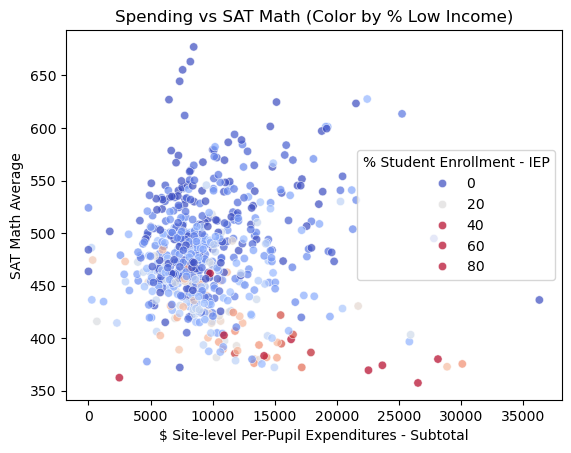

In [61]:
sns.scatterplot(
    data=df19,
    x='$ Site-level Per-Pupil Expenditures - Subtotal',
    y='SAT Math Average',
    hue='% Student Enrollment - IEP',
    palette='coolwarm',
    hue_norm=(10, 30),  # Adjust based on your data distribution
    alpha=0.7
)
plt.title("Spending vs SAT Math (Color by % Low Income)")
plt.show()



#### Interestingly, for higher income students, it seems more per pupil spending is positively correlated with SAT scores. But for low income students, this is not the case. More spending might even be negatively correlated with SAT scores, but this might be because for low income schools, more spending is correlated with a higher special education population (% IEP Enrollment)

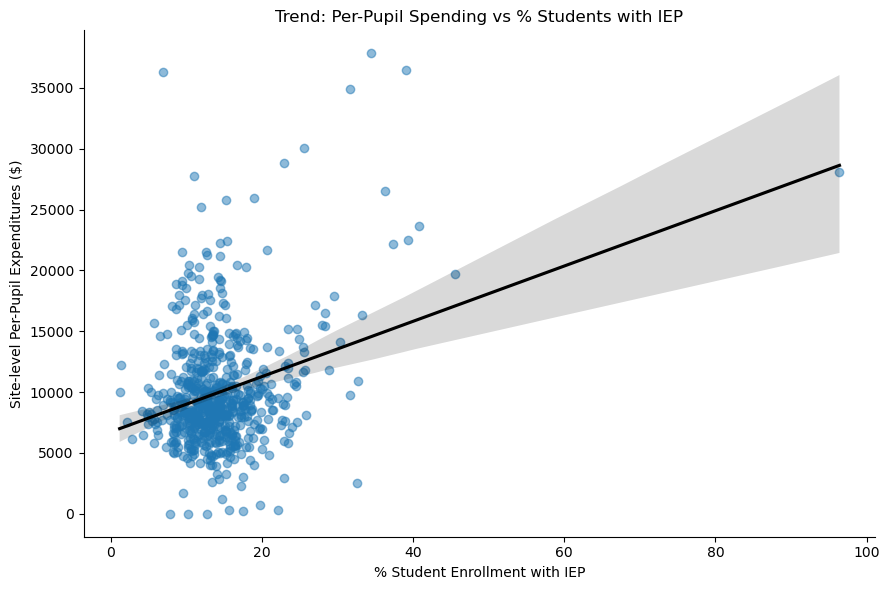

In [63]:
sns.lmplot(
    data=df19,
    y='$ Site-level Per-Pupil Expenditures - Subtotal',
    x='% Student Enrollment - IEP',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'black'},
    height=6,
    aspect=1.5
)
plt.title("Trend: Per-Pupil Spending vs % Students with IEP")
plt.ylabel("Site-level Per-Pupil Expenditures ($)")
plt.xlabel("% Student Enrollment with IEP")
plt.tight_layout()
plt.show()


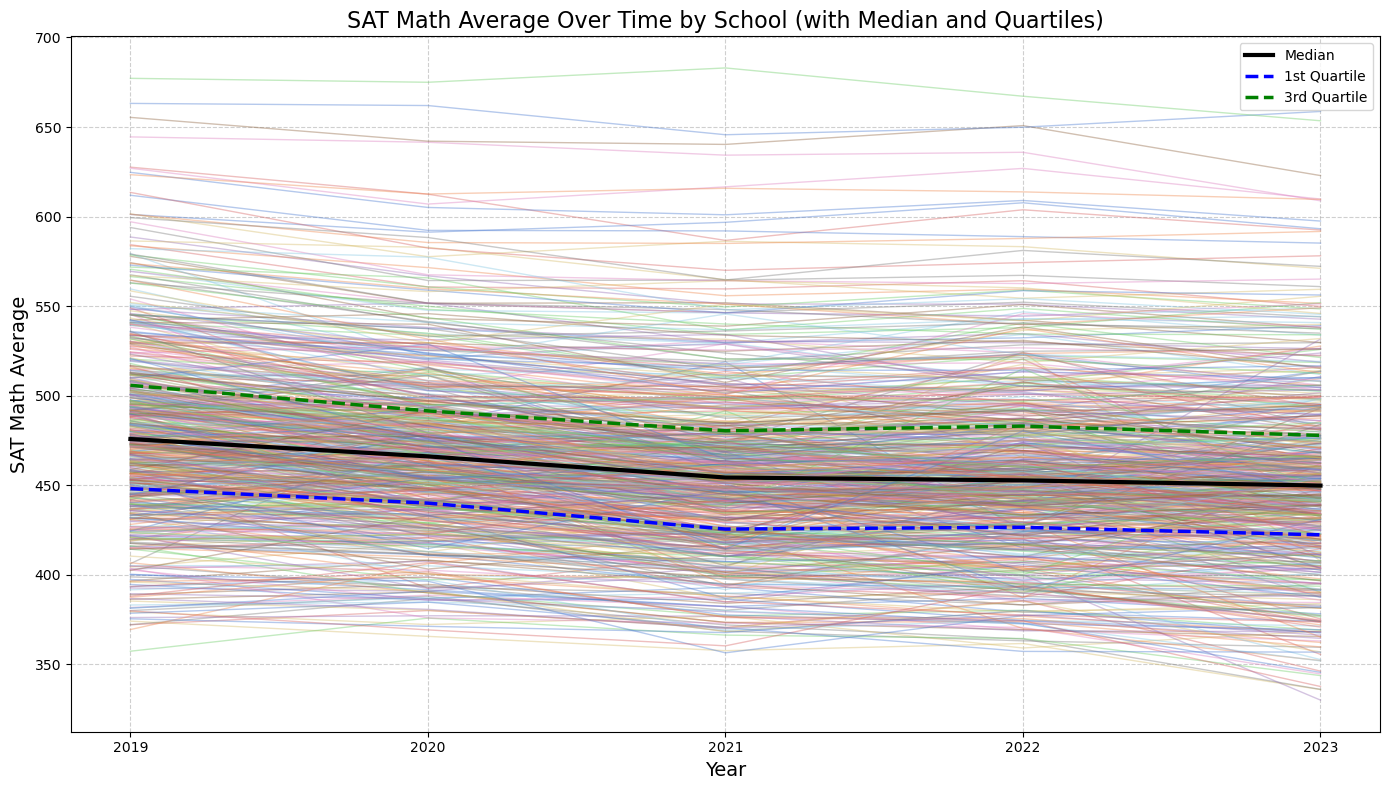

In [47]:
# Remove duplicates (if duplicate rows aren't necessary)
df_combined = df_combined.groupby(['RCDTS', 'Year'], as_index=False).agg({'SAT Math Average': 'mean'})

#Find only those schools for which we have data from each year
all_years = sorted(df_combined['Year'].unique())
year_counts = df_combined['RCDTS'].value_counts()
complete_schools = year_counts[year_counts == len(all_years)].index

# Keep only those rows
df_filtered = df_combined[df_combined['RCDTS'].isin(complete_schools)]


#Make Sphagghetti Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_filtered,
    x='Year',
    y='SAT Math Average',
    hue='RCDTS',
    palette='muted',
    linewidth=1,
    alpha=0.4,
    legend=False
)

# Step 2: Compute summary stats for each year
summary_stats = df_filtered.groupby('Year')['SAT Math Average'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).reset_index()
summary_stats.columns = ['Year', 'Median', 'Q1', 'Q3']

# Step 3: Overlay bold lines
plt.plot(summary_stats['Year'], summary_stats['Median'], color='black', linewidth=3, label='Median')
plt.plot(summary_stats['Year'], summary_stats['Q1'], color='blue', linewidth=2.5, linestyle='--', label='1st Quartile')
plt.plot(summary_stats['Year'], summary_stats['Q3'], color='green', linewidth=2.5, linestyle='--', label='3rd Quartile')

# Final styling
plt.title('SAT Math Average Over Time by School (with Median and Quartiles)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('SAT Math Average', fontsize=14)
plt.xticks(summary_stats['Year'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



# Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Define features
selected_features = [
    'Student Attendance Rate',
    'Teacher Retention Rate',
    '% Student Enrollment - Asian',
    '# Student Enrollment',
    'Percent Teachers With Masters Degree',
    'Admin Avg Salary',
    'Teacher Avg Salary',
    'Teacher Attendance Rate',
    '% Student Enrollment - White',
    '% Student Enrollment - Low Income',
    'Chronic Absenteeism',
    'High School Dropout Rate - Total',
    'Student Chronic Truancy Rate',
    '% Student Enrollment - IEP',
    '% Student Enrollment - Black or African American'
]

# List of dataframes
dfs = [df19, df20, df21, df22, df23]
train_test_splits = {}




# Loop through each DataFrame (df19, df20, etc.), fix a train test split for each year
for year, df in zip([2019, 2020, 2021, 2022, 2023], dfs):
    # Drop rows with missing values in either features or target
    df_model = df.dropna(subset=selected_features + ['SAT Math Average'])
    
    # Feature matrix X and target vector y
    X = df_model[selected_features]
    y = df_model['SAT Math Average']
    
    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=11
    )
    
    # Store the splits in the dictionary
    train_test_splits[year] = {
        'X_train': X_train, 'X_test': X_test, 
        'y_train': y_train, 'y_test': y_test
    }


#### We start with a KNN regressor.

In [ ]:
# List to store the naive model MSE for each year
naive_MSE = []

for year in [2019, 2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split
    X_train = train_test_splits[year]['X_train']
    X_test = train_test_splits[year]['X_test']
    y_train = train_test_splits[year]['y_train']
    y_test = train_test_splits[year]['y_test']
    
    # Naive prediction: mean of the training targets
    y_pred_naive = [y_train.mean()] * len(y_test)
    
    # Compute MSE
    mse_naive = mean_squared_error(y_test, y_pred_naive)
    naive_MSE.append(mse_naive)
    
    print(f"Naive Model MSE for {year}: {mse_naive:.2f}")


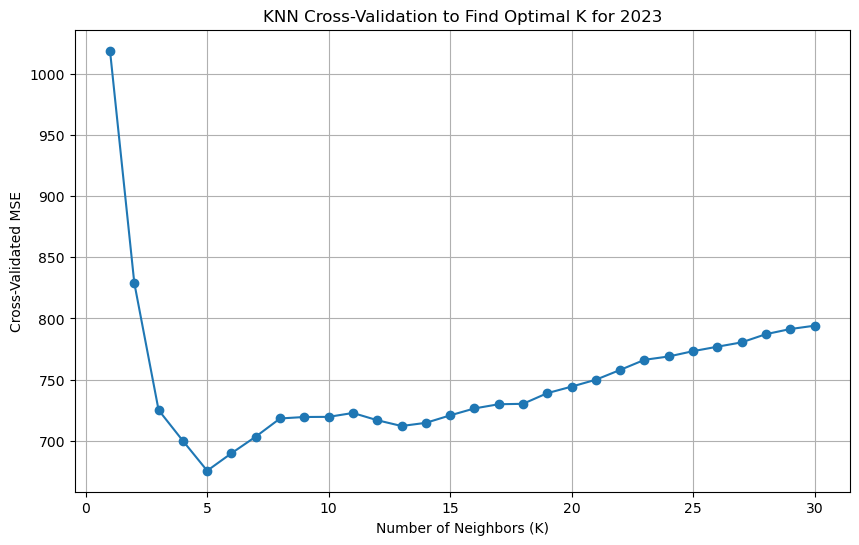

Best K value for 2023: 5 with MSE: 675.61


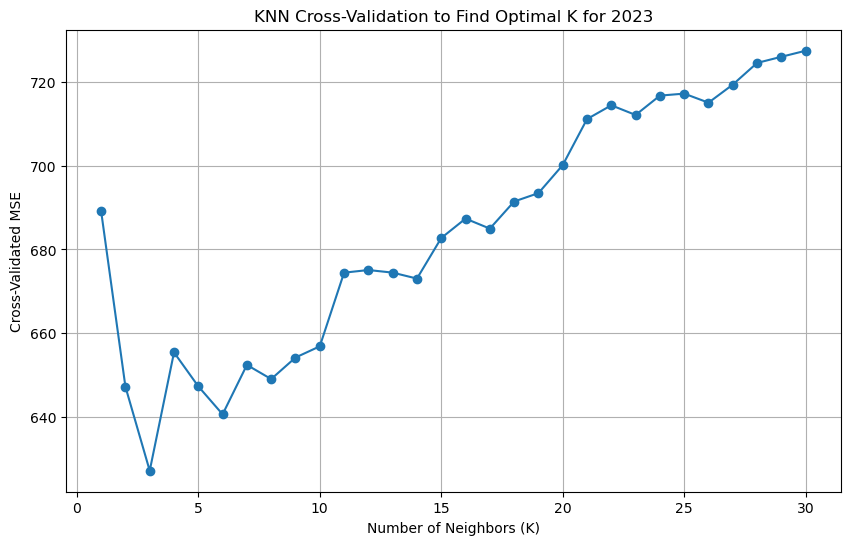

Best K value for 2023: 3 with MSE: 627.08


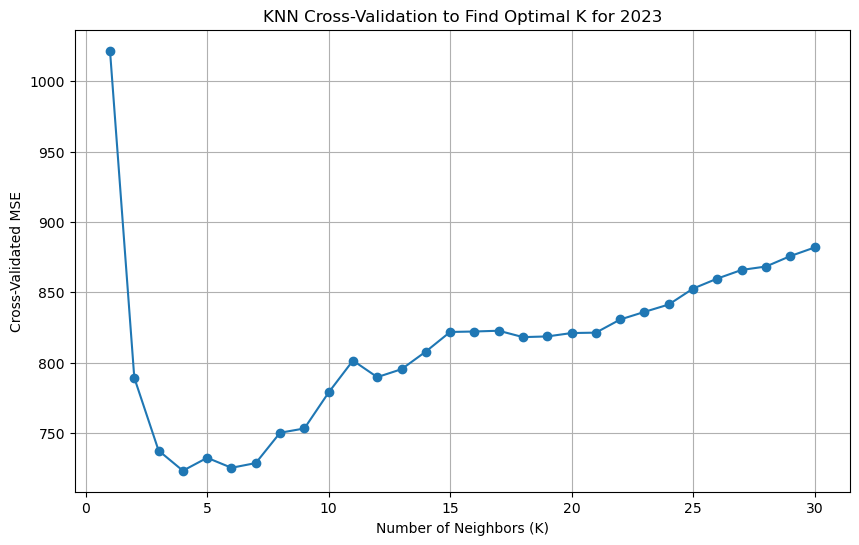

Best K value for 2023: 4 with MSE: 723.11


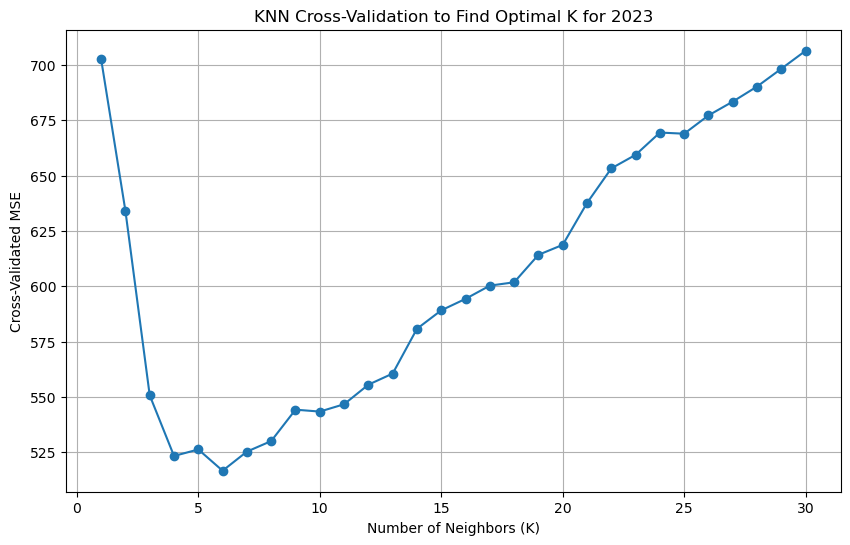

Best K value for 2023: 6 with MSE: 516.57


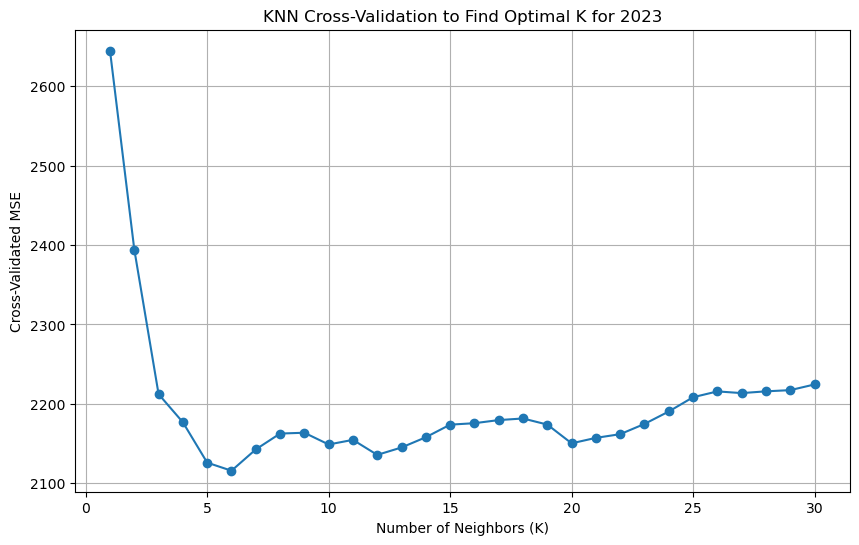

Best K value for 2023: 6 with MSE: 2115.82


In [ ]:



#A list that will store our KNN-MSE for each year
KNN_MSE = []


# Loop over each dataframe (df19 to df23), train KNN regressor for each year
for year in [2019, 2020, 2021, 2022, 2023]:
    # Access the pre-defined train-test split for the year
    X_train = train_test_splits[year]['X_train']
    X_test = train_test_splits[year]['X_test']
    y_train = train_test_splits[year]['y_train']
    y_test = train_test_splits[year]['y_test']
    
    k_values = range(1, 31)
    mean_scores = []
    
    # Pick k with best cross-validation error
    for k in k_values:
        knn_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # Negative MSE (we'll take the negative again to get positive values)
        scores = cross_val_score(knn_pipeline, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
        mean_scores.append(-scores.mean())
    
    # Plot the results for each dataframe
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mean_scores, marker='o')
    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("Cross-Validated MSE")
    plt.title(f"KNN Cross-Validation to Find Optimal K for {df['Year'].iloc[0]}")
    plt.grid(True)
    plt.show()
    
    # Best K for current dataframe
    best_k = k_values[np.argmin(mean_scores)]

    best_mse = min(mean_scores)

    # Store the MSE for this year
    KNN_MSE.append(best_mse)
    
    print(f"Best K value for {df['Year'].iloc[0]}: {best_k} with MSE: {min(mean_scores):.2f}")


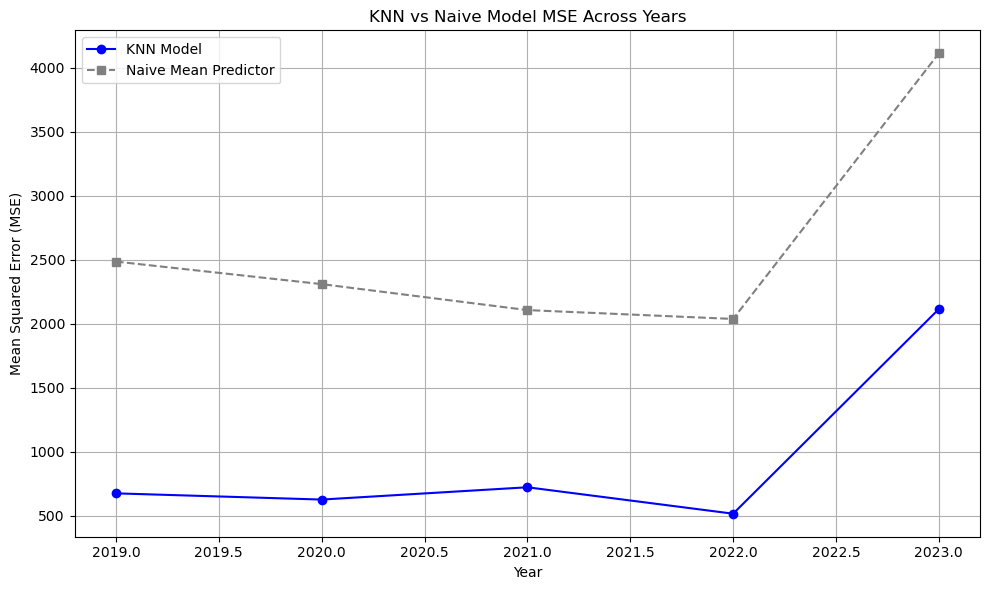

In [82]:
plt.figure(figsize=(10, 6))

# Plot KNN MSE
plt.plot([2019, 2020, 2021, 2022, 2023], KNN_MSE, 
         marker='o', linestyle='-', color='b', label='KNN Model')

# Plot Naive MSE
plt.plot([2019, 2020, 2021, 2022, 2023], naive_MSE, 
         marker='s', linestyle='--', color='gray', label='Naive Mean Predictor')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("KNN vs Naive Model MSE Across Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Naive Model MSE for 2019: 2486.80
Naive Model MSE for 2020: 2310.61
Naive Model MSE for 2021: 2107.68
Naive Model MSE for 2022: 2038.49
Naive Model MSE for 2023: 4113.97
